In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt

In [9]:
input_shape = (224, 224, 3)  
batch_size = 64
num_epochs = 20 

In [10]:
preprocessed_path = r"D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

print("Setting up Training Generator...")
train_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'train'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',
    shuffle=True             
)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes in training set.")

print("\nSetting up Validation Generator...")
val_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'val'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',            
    shuffle=False                # No need to shuffle validation data
)
print(f"Found {val_generator.samples} images belonging to {val_generator.num_classes} classes in validation set.")

print("\nSetting up Testing Generator...")
test_generator = train_datagen.flow_from_directory(
    os.path.join(preprocessed_path, 'test'),
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='sparse',         
    color_mode='rgb',            
    shuffle=False                # No need to shuffle training data
)
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes in validation set.")


Setting up Training Generator...
Found 30580 images belonging to 10 classes.
Found 30580 images belonging to 10 classes in training set.

Setting up Validation Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.

Setting up Testing Generator...
Found 328 images belonging to 10 classes.
Found 328 images belonging to 10 classes in validation set.


In [11]:
# --- Build VGG16 Model ---
print("\nBuilding VGG16 model...")
# Load VGG16 base pre-trained on ImageNet, exclude top classification layer
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# 2) Freeze early blocks, fine-tune later ones
for layer in base_model.layers[:-2]:
    layer.trainable = False
print(f"VGG16 base model loaded. Trainable: {base_model.trainable}")

# Create the new model head
vgg16_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.Dense(512, activation='relu', name='fc1'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_1'), 
    layers.Dense(256, activation='relu', name='fc2'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_2'), 
    layers.Dense(128, activation='relu', name='fc3'),
    layers.BatchNormalization(),
    layers.Dropout(0.75, name='dropout_3'), 
    layers.Dense(10, activation='softmax', name='predictions') 
], name="VGG16_Transfer_Learning")

# --- Compile Model ---
optimizer = Adam(learning_rate=0.0001) 

vgg16_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

print("\nModel Summary:")
vgg16_model.summary()


Building VGG16 model...
VGG16 base model loaded. Trainable: True

Model Summary:


Model: "VGG16_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,146,442 (57.78 MB)

 Trainable params: 2,789,770 (10.64 MB)

 Non-trainable params: 12,356,672 (47.14 MB)

In [13]:
# --- Define Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,          
    verbose=1,
    restore_best_weights=True 
)

model_checkpoint = ModelCheckpoint(
    filepath='best_vgg16_model.keras', 
    monitor='val_loss',
    save_best_only=True, 
    verbose=1
)

In [14]:
print(f"\nStarting training for up to {num_epochs} epochs (head only)...")
history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size, 
    epochs=num_epochs,
    callbacks=[early_stopping, model_checkpoint] 
)
print("\nTraining finished.")


Starting training for up to 20 epochs (head only)...


c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1206 - loss: 4.1321
Epoch 1: val_loss improved from inf to 1.66068, saving model to best_vgg16_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 1622s 3s/step - accuracy: 0.1207 - loss: 4.1315 - val_accuracy: 0.4281 - val_loss: 1.6607
Epoch 2/20
  1/477 ━━━━━━━━━━━━━━━━━━━━ 28:19 4s/step - accuracy: 0.1719 - loss: 3.4597

c:\Users\omarn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.66068
477/477 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.1719 - loss: 3.4597 - val_accuracy: 0.4313 - val_loss: 1.6615
Epoch 3/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2091 - loss: 3.0618
Epoch 3: val_loss improved from 1.66068 to 1.26828, saving model to best_vgg16_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 1510s 3s/step - accuracy: 0.2091 - loss: 3.0614 - val_accuracy: 0.5469 - val_loss: 1.2683
Epoch 4/20
  1/477 ━━━━━━━━━━━━━━━━━━━━ 26:15 3s/step - accuracy: 0.3438 - loss: 2.2815
Epoch 4: val_loss did not improve from 1.26828
477/477 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.3438 - loss: 2.2815 - val_accuracy: 0.5469 - val_loss: 1.2712
Epoch 5/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3059 - loss: 2.3594
Epoch 5: val_loss improved from 1.26828 to 1.10469, saving model to best_vgg16_model.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 1543s 3s/step - accuracy: 0.3059 - loss: 2.3592 - val_accuracy: 0.5844 - val_lo

In [15]:
model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

In [17]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    directory=r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_RGB_images\test',    
    target_size=input_shape[:2],           
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False                           
)

Found 328 images belonging to 10 classes.


In [18]:
tf.keras.backend.clear_session()

model = load_model(r'D:\FUCK!!\Pattern\Project\Models\best_vgg16_model.keras')

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True    
)

loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {loss:.4f} — Test accuracy: {acc:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8479 - loss: 0.5037

Test loss: 0.5685 — Test accuracy: 0.8232


In [19]:
steps = int(np.ceil(test_gen.samples / batch_size))
pred_probs = model.predict(
    test_gen,
    steps = steps,
    verbose=1
)

pred_idxs = np.argmax(pred_probs, axis=1)
true_idxs = test_gen.classes
labels   = list(test_gen.class_indices.keys())

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


In [20]:
print("\nClassification Report:\n")
print(classification_report(true_idxs, pred_idxs, target_names=labels))


Classification Report:

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.84      1.00      0.91        48
American Foursquare architecture       0.83      0.87      0.85        45
        American craftsman style       0.74      0.68      0.71        25
   Ancient Egyptian architecture       1.00      0.61      0.76        23
           Art Deco architecture       0.88      0.73      0.80        30
        Art Nouveau architecture       0.81      0.84      0.82        25
            Baroque architecture       0.71      0.73      0.72        33
            Bauhaus architecture       0.91      0.97      0.94        33
         Beaux-Arts architecture       0.75      0.69      0.72        35
          Byzantine architecture       0.83      0.94      0.88        31

                        accuracy                           0.82       328
                       macro avg       0.83      0.80      0.81       328
           

In [21]:
print("\nConfusion Matrix:\n")
print(confusion_matrix(true_idxs, pred_idxs))


Confusion Matrix:

[[48  0  0  0  0  0  0  0  0  0]
 [ 0 39  6  0  0  0  0  0  0  0]
 [ 0  8 17  0  0  0  0  0  0  0]
 [ 9  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  1  3  3  1]
 [ 0  0  0  0  0 21  1  0  2  1]
 [ 0  0  0  0  0  3 24  0  2  4]
 [ 0  0  0  0  1  0  0 32  0  0]
 [ 0  0  0  0  2  2  7  0 24  0]
 [ 0  0  0  0  0  0  1  0  1 29]]


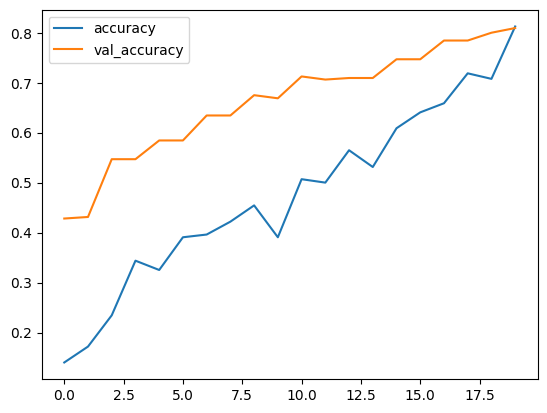

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.show()

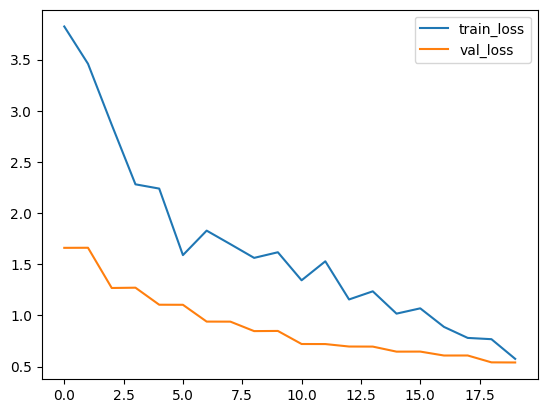

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.show()